In [ ]:
!pip install scikit-fuzzy

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset paths
base_dir = "/content/drive/MyDrive/Dataset/Brain Tumor Data Set"

# Parameters
img_size = (150, 150)
batch_size = 32

# Data generators with normalization and train-validation split
datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

# Generate training and validation data
train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 3750 images belonging to 2 classes.
Found 936 images belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

# Assuming the MRI dataset is placed in separate folders for each class (e.g., "brain_tumor" and "no_tumor")
data_dir = '/content/drive/MyDrive/Dataset/Brain Tumor Data Set'

# Load the images and their labels
def load_data():
    images = []
    labels = []
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        # Check if the item is a directory before iterating through it
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = image.load_img(img_path, target_size=(150, 150))
                img = image.img_to_array(img)
                images.append(img)
                labels.append(1 if folder == 'Brain Tumor' else 0)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load dataset
X, y = load_data()

# Normalize images
X = X / 255.0

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Assuming X_train, X_test, y_train, y_test are already prepared and normalized

# Build the CNN model
model = Sequential()

# Add convolutional and pooling layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and add fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.7))  # Dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.6297 - loss: 0.6658 - val_accuracy: 0.7569 - val_loss: 0.4602
Epoch 2/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.7976 - loss: 0.4399 - val_accuracy: 0.8667 - val_loss: 0.2951
Epoch 3/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.8376 - loss: 0.3361 - val_accuracy: 0.9307 - val_loss: 0.2387
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 539ms/step - accuracy: 0.9348 - loss: 0.2277
Test Accuracy: 93.07%


In [ ]:
import numpy as np
import skfuzzy as fuzz

def apply_fuzzy_logic(prediction):
    """
    Apply fuzzy logic to refine the decision. If the CNN model is unsure, fuzzy logic
    will help make a more confident decision based on a fuzzy set.
    """
    # Define the universe of discourse
    x = np.arange(0, 1.01, 0.01)  # From 0 to 1 with a step of 0.01

    # Fuzzy membership functions
    low_confidence = fuzz.trimf(x, [0, 0, 0.5])  # Fuzzy set for low confidence
    high_confidence = fuzz.trimf(x, [0.5, 1, 1])  # Fuzzy set for high confidence

    # Fuzzify the CNN output
    low_membership = fuzz.interp_membership(x, low_confidence, prediction)
    high_membership = fuzz.interp_membership(x, high_confidence, prediction)

    # Decision rules
    if high_membership > low_membership:
        return 1  # Tumor detected
    else:
        return 0  # No tumor detected

# Analyze all test images
results = []  # List to store results for all test images

for i, sample_img in enumerate(X_test):
    # Preprocess the sample image to match input shape
    sample_img = sample_img.reshape(1, 150, 150, 3)

    # Get CNN prediction
    cnn_prediction = model.predict(sample_img)

    # Apply fuzzy logic
    refined_prediction = apply_fuzzy_logic(cnn_prediction[0][0])

    # Store the result
    results.append(refined_prediction)
    status = "Tumor detected" if refined_prediction == 1 else "No tumor detected"
    print(f"Image {i + 1}: {status}")

# Summary
num_tumors = results.count(1)
num_healthy = results.count(0)

print("\nSummary of Analysis:")
print(f"Total Images Analyzed: {len(results)}")
print(f"Tumor Detected: {num_tumors}")
print(f"No Tumor Detected: {num_healthy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Image 1: Tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Image 2: Tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Image 3: No tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Image 4: Tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Image 5: Tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Image 6: Tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Image 7: Tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Image 8: No tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Image 9: No tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Image 10: Tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Image 11: Tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Image 12: Tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Image 13: Tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Image 14: Tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Image 15: Tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Image 16: No 

30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 503ms/step
Tumor Detected:


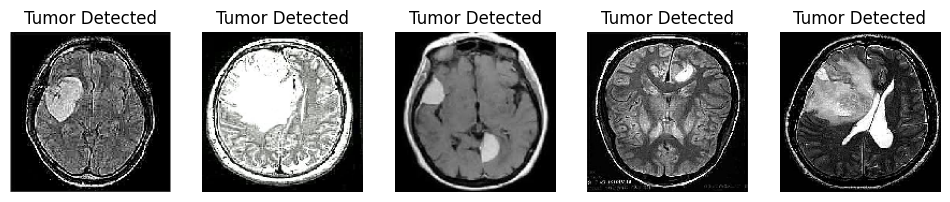

No Tumor Detected:


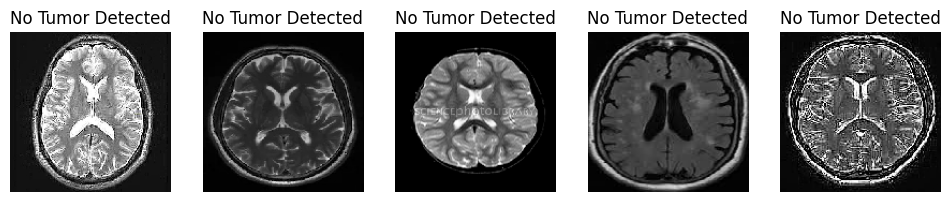

In [ ]:
import matplotlib.pyplot as plt

# Predict on the test dataset
predictions = model.predict(X_test)

# Initialize lists to store indices of detected and not detected tumors
tumor_detected_indices = []
no_tumor_detected_indices = []

# Categorize predictions
for i, prediction in enumerate(predictions):
    if prediction >= 0.5:  # Tumor detected
        tumor_detected_indices.append(i)
    else:  # No tumor detected
        no_tumor_detected_indices.append(i)

# Function to plot images
def plot_images(indices, title, num_images=5):
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(indices[:num_images]):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_test[idx])
        plt.title(f"{title}")
        plt.axis("off")
    plt.show()

# Plot 5 images each
print("Tumor Detected:")
plot_images(tumor_detected_indices, "Tumor Detected")

print("No Tumor Detected:")
plot_images(no_tumor_detected_indices, "No Tumor Detected")


30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 527ms/step
Evaluation Metrics:
Accuracy: 0.93
Precision: 0.93
Recall: 0.94
F1 Score: 0.94


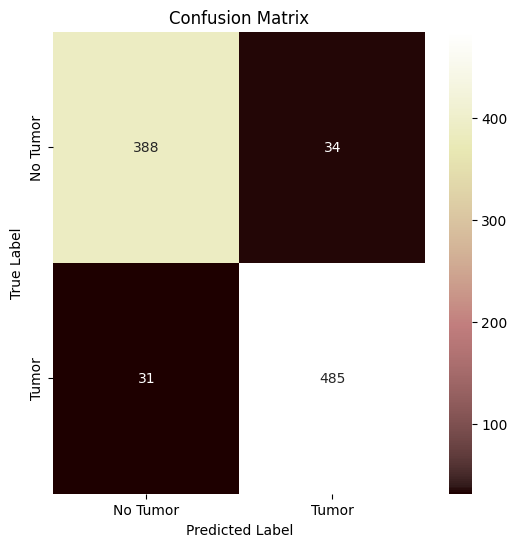


Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.93      0.92      0.92       422
       Tumor       0.93      0.94      0.94       516

    accuracy                           0.93       938
   macro avg       0.93      0.93      0.93       938
weighted avg       0.93      0.93      0.93       938



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions from the model
y_pred_prob = model.predict(X_test)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary (0 or 1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='pink', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Tumor', 'Tumor']))
